In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.stats import lognorm
import os
from pathlib import Path
import sys

sys.path.append('../../../analyzing_serverless_in_the_wild')

import process_data
import source.utilities as utilities 

In [ ]:
EX_days = Mem_days = range(1, 3)

minute= 1440

plot_dir = "plots"
Path(plot_dir).mkdir(parents=True, exist_ok=True)

plt.rcParams['figure.figsize'] = [7, 3]

data = process_data.Dataset( EX_days, Mem_days, minute)

memory_data = data.df_memory
invocation_data = data.df_invocations_per_function
duration_data = data.df_durations

# memory_data = memory_data[['HashApp', 'SampleCount', 'AverageAllocatedMb']]
memory_data['AllocatedMemory'] = memory_data['SampleCount'] * memory_data['AverageAllocatedMb']
invocation_data['InvocationCount'] = invocation_data.loc[:, '1':'1440'].sum(axis=1)
invocation_data = invocation_data[['HashApp', 'InvocationCount']]

df = pd.merge(memory_data, invocation_data, on='HashApp')
df = df[['InvocationCount', 'AllocatedMemory']]

Parsing azurefunctions-dataset2019, days: 2, minutes: 1440


Parsing Data: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


In [ ]:
def plot_avg_interval_between_invocations(data):

    df_functions = data.df_invocations_per_function.copy()

    daily_to_average = {
        1: '1d',
        2: '12h',
        24: '1h',
        48: '30',
        96: '15',
        288: '5',
        1440: '1min',
        86_400: '1s',
    }

    df_functions['TotalInvocations'] = df_functions.loc[:, '1':'1440'].sum(axis=1)
    df_apps = df_functions.groupby('HashApp').sum()
    df_functions = df_functions.sort_values('TotalInvocations')
    df_apps = df_apps.sort_values('TotalInvocations')

    df_functions['Fraction'] = np.arange(1, len(df_functions) + 1) / len(df_functions)
    df_apps['Fraction'] = np.arange(1, len(df_apps) + 1) / len(df_apps)

    fig, ax1 = plt.subplots()
    ax1.semilogx(df_apps['TotalInvocations'], df_apps['Fraction'], label='Applications')
    ax1.semilogx(df_functions['TotalInvocations'], df_functions['Fraction'], label="Functions", linestyle='--')
    
    ax1.grid(True, which='both', axis='y')

    ax1.set_xlabel('Daily Invocations per App')
    ax1.set_ylabel('Fraction of Apps')
        
    secax = ax1.secondary_xaxis('top')
    secax.set_xscale('log')

    custom_ticks  = list(daily_to_average.keys())
    secax.set_xticks(custom_ticks)
    secax.set_xticklabels(list(daily_to_average.values()))

    secax.minorticks_off()

    for tick in custom_ticks:
        ax1.axvline(x=tick, color='gray', linestyle='-', linewidth=0.8)
    plt.legend()
    plt.savefig(os.path.join(plot_dir, "avg_interval_between_invocations.pdf"), bbox_inches='tight')
    plt.show()

In [ ]:
def plot_memory_percentiles(df):
    percentiles = [1, 50, 100]
    labels = ['1st Percentile', 'Average', 'Maximum']
    colors = ['green', 'red', 'blue']
    linestyles = [':', '-', '--']

    fig, ax = plt.subplots()

    for pct, label, color, linestyle in zip(percentiles, labels, colors, linestyles):
        allocated_memory = df[f'AverageAllocatedMb_pct{pct}']
        cdf = np.arange(len(allocated_memory)) / float(len(allocated_memory))
        ax.plot(np.sort(allocated_memory), cdf, label=label, color=color, linestyle=linestyle)

    ax.set_xscale('log')

    ax.set_xticks([10, 100, 1000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    ax.set_xlabel('Allocated Memory (MB)')
    ax.set_ylabel('CDF')
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.savefig(os.path.join(plot_dir, "memory_percentiles.pdf"), bbox_inches='tight')
    plt.show()


In [ ]:
def plot_cumulative_memory_usage(df):
    
    df_sorted = df.sort_values('InvocationCount')

    df_sorted['CumulativeAllocatedMemory'] = df_sorted['AllocatedMemory'].cumsum()
    total_memory = df_sorted['AllocatedMemory'].sum()
    df_sorted['FractionOfTotalMemory'] = df_sorted['CumulativeAllocatedMemory'] / total_memory

    df_sorted = df_sorted.reset_index(drop=True)
    x = df_sorted.index / df_sorted.index.max()
    
    plt.figure()
    plt.plot(x, df_sorted['FractionOfTotalMemory'], 
             color='red', label='Allocated Memory', linewidth=2)
    
    plt.xlabel('Fraction of Least Invoked Apps')
    plt.ylabel('Cumulative Fraction of Total Memory')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    
    plt.savefig(os.path.join(plot_dir, "cumulative_memory_usage.pdf"), bbox_inches='tight')
    plt.show()


In [ ]:
def plot_cumulative_duration(df):

    ms_calc = {
        1: '1ms',
        100: '100ms',
        1000: '1s',
        10_000: '10s',
        60_000: '1m',
        600_000: '10m',
        3_600_000: '1h',
    }

    df_pos = df[df['Minimum'] > 0]

    shape, loc, scale = lognorm.fit(df_pos['Average'], floc=0) 

    x = np.logspace(np.log10(min(df_pos['Average'])), np.log10(max(df_pos['Average'])), df_pos.shape[0])
    cdf = lognorm.cdf(x, shape, loc=loc, scale=scale)

    df_pos = df_pos.reset_index(drop=True)
    df_pos = df_pos.sort_values('Average')

    y = df_pos.index.to_series().cumsum()
    y = y/y.max()

    fig, ax = plt.subplots()

    ax.plot(x, cdf, 'k--', label='LogNormal Fit')

    graphs = [{'Name': 'Minimum', 'Color': 'tab:green', 'Linestyle': '-.'},
                  {'Name': 'Average', 'Color': 'tab:red', 'Linestyle': '-'},
                  {'Name': 'Maximum', 'Color': 'tab:blue', 'Linestyle': '--'}]

    for graph in graphs:
        df_pos = df_pos.sort_values(graph['Name'])
        ax.plot(df_pos[graph['Name']], y, label=graph['Name'], color=graph['Color'], linestyle=graph['Linestyle'])

    plt.xscale('log')

    custom_ticks  = list(ms_calc.keys())
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(list(ms_calc.values()))

    ax.minorticks_off()

    plt.xlabel('Time(s)')
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(plot_dir, "cumulative_duration.pdf"), bbox_inches='tight')
    plt.show()

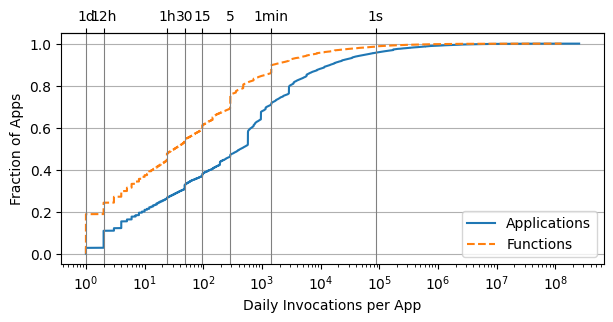

In [8]:
plot_avg_interval_between_invocations(data)

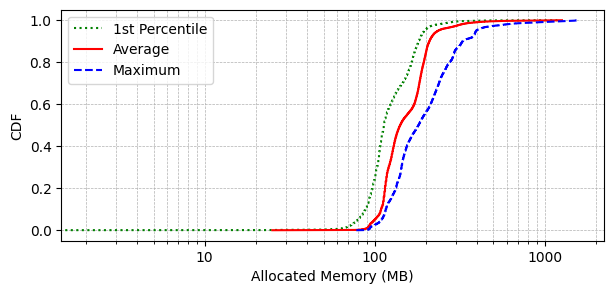

In [22]:
plot_memory_percentiles(memory_data)

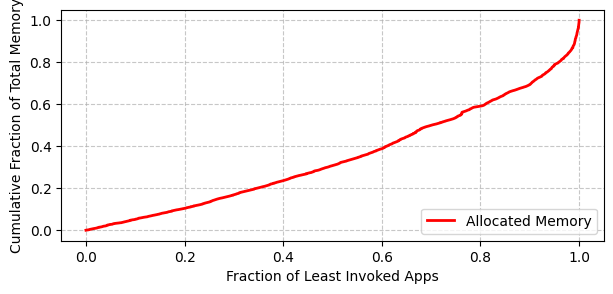

In [11]:
plot_cumulative_memory_usage(df)

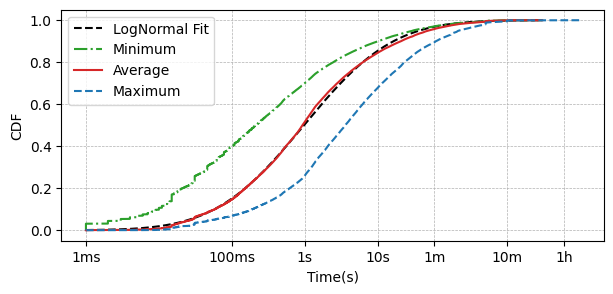

In [17]:
plot_cumulative_duration(duration_data)